In [2]:
import json
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#coursera metadata
c_courselist = json.load(open('./data/coursera_courses.json'))

# extract the categories -- elements are unique
c_catnames = {ele['name'] for ele in c_courselist['linked']['categories']}

In [4]:
# pull in wikibooks XML
et = ET.parse('./data/wikibooks/enwikibooks-20150603-pages-articles-multistream.xml')
root = et.getroot()

In [5]:
def add_ns(tag, namespace='{http://www.mediawiki.org/xml/export-0.10/}'):
    """add namespace prefix to tag"""
    return namespace+tag

In [14]:
# root.findall(add_ns('page')) gets all page nodes

# find all title nodes for all pages
title_nodes = root.findall("./%s/%s" % (add_ns('page'), add_ns('title')))

In [15]:
# get titles from each title node
title_list = [title.text for title in title_nodes]
print title_list[:5]
# notice how there's a / structure. 
# Organic chemistry
# Organic chemistry/concept 1
# Organic chemistry/concept 2

# Idea: find all concept paths
# Create tree based on splitting on '/'
# len(split) is depth of tree

['Main Page', 'Organic Chemistry/Cover', 'Organic Chemistry/Foundational concepts of organic chemistry', 'Organic Chemistry/Introduction to reactions', 'Organic Chemistry/Alkenes']


In [16]:
derived_only = [title for title in title_list if '/' in set(title)]

In [17]:
derived_only_no_cookbooks = \
[title for title in derived_only if not title.startswith('Cookbook:')]

In [18]:
titles_split = [title.split('/') for title in derived_only_no_cookbooks]

In [19]:
split_size = [len(split) for split in titles_split]
print max(split_size) #29

29


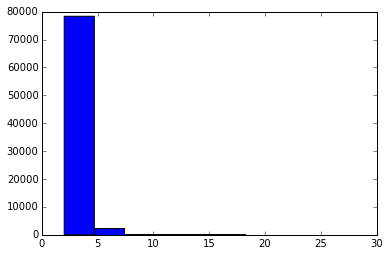

In [20]:
plt.hist(split_size)
plt.show()

In [21]:
for i, size in enumerate(split_size):
    if size > 5:
        print titles_split[i]
        
# mostly chess opening theory, or excessively nested structure
# will leave it alone for now, as these nodes will likely not get used in later implementations
# potentially will res

['C++ Programming', 'Programming Languages', 'C++', 'Code', 'Statements', 'Flow Control']
['FHSST Biology', 'Contents', 'Index', 'SCP', 'Energy', 'Photosynthesis']
['FHSST Biology', 'Contents', 'Index', 'DCC', 'Origin of species', 'Theories', 'Evolution']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Ecosystems', 'Biospheres, biomes and ecosystems']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Ecosystems', 'Resources']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Ecosystems', 'Resources', 'Energy flow within environments']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Human Influence', 'Air']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Human Influence', 'Water']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Human Influence', 'Land']
['FHSST Biology', 'Contents', 'Index', 'ES', 'Ecosystems', 'Resources', 'Biotic (living) and Abiotic (non-living) resources']
['Chess Opening Theory', '1. e4', '1...e5', '2. Nf3', '2...Nc6', '3. Bc4']
['Chess Opening Theory', '1. e4', '1...e5', '2. Nf3'

In [82]:
#construct dict for converting pageIDs to titles
pageid_title_dict = {}
# pages = root.findall(add_ns('page'))
for page in root:
    pageid_title_dict[page[2].text] = page[0].text
    
def pageid_to_title(pageid, pageid_title_dict):
    return pageid_title_dict.get(str(pageid), np.NaN) #due to missing page names from wiki dump

# 1308 The Once and Future King/The Sword in the Stone/Chapter 17
print root[500][2].text, root[500][0].text 
print pageid_to_title(1308, pageid_title_dict)

1308 The Once and Future King/The Sword in the Stone/Chapter 17
The Once and Future King/The Sword in the Stone/Chapter 17


In [85]:
# read in path CSV
df = pd.read_csv('./data/wikibooks_3_path.csv', header=None)
df.columns = ['category', 'page1', 'page2']
df.page1.unique

<bound method Series.unique of 0     76
1     76
2     76
3     76
4     76
5     76
6     76
7     76
8     76
9     76
10    76
11    76
12    76
13    76
14    76
...
4787    361302
4788    361302
4789    361302
4790    361302
4791    361302
4792    361302
4793    361302
4794    361302
4795    361302
4796    361302
4797    361302
4798    361302
4799    361302
4800    361302
4801    361302
Name: page1, Length: 4802, dtype: int64>

In [89]:
df.page1 = df.page1.apply(pageid_to_title, args=(pageid_title_dict,))

print df.shape # 4802, 3
print df.head


UnicodeEncodeError: 'ascii' codec can't encode character u'\xf3' in position 24: ordinal not in range(128)

In [90]:
df.head() # page2 is sometimes page1/derived page eg Modern_Physics/Constants

,category,page1,page2
0,Physics,Modern Physics,Electrodynamics
1,Physics,Modern Physics,General_Mechanics
2,Physics,Modern Physics,Mechanics
3,Physics,Modern Physics,Modern_Physics/Constants
4,Physics,Modern Physics,Modern_Physics/For_Contributors


# BUILDING OUT THE GRAPH

In [91]:
import networkx as nx

array(['Physics', 'Chemistry', 'Engineering', 'Law', 'Social_sciences',
       'Medicine', 'Education', 'Mathematics'], dtype=object)

In [123]:
G = nx.Graph()
graph_df = df.dropna()
for col in df.columns:
    for value in graph_df[col].unique():
        G.add_node(value)
        
for row in graph_df.iterrows():
    G.add_path(row[1].values)

In [128]:
print G.number_of_edges()
print G.number_of_nodes()

4930
4640


In [24]:
# add each unique list element as a node
# iterate through the list creating edges from one item to the item to its right

titles_split[0]

['Organic Chemistry', 'Cover']

In [25]:
test1 = set(titles_split[0])
test2 = set(titles_split[1])
print test1
print test2

set(['Organic Chemistry', 'Cover'])
set(['Organic Chemistry', 'Foundational concepts of organic chemistry'])


In [26]:
unique_elements = set()
for title in titles_split:
    unique_elements = unique_elements.union(title)

In [27]:
len(unique_elements)

58939

In [28]:
node_concept_dict = {k: v for k,v in enumerate(unique_elements)}
G.add_edge

<bound method Graph.add_edge of <networkx.classes.graph.Graph object at 0x23acb83d0>>

In [29]:
G.add_nodes_from(node_concept_dict.keys())

In [30]:
dg = nx.DiGraph()
dg.add_nodes_from(unique_elements)            

In [31]:
for concept_list in titles_split:
    dg.add_path(concept_list)

In [132]:
cat_dict = {}
for x in c_catnames:
    cat_dict[x] = x.split()

In [133]:
{u'Arts': [u'Arts'],
 u'Biology & Life Sciences': [u'Biology', u'Life Sciences'],
 u'Business & Management': [u'Business', u'Management'],
 u'Chemistry': [u'Chemistry'],
 u'Computer Science: Artificial Intelligence': [u'Computer Science',
  u'Artificial Intelligence'],
 u'Computer Science: Software Engineering': [u'Computer Science',
  u'Software Engineering'],
 u'Computer Science: Systems & Security': [u'Computer Science'],
 u'Computer Science: Theory': [u'Computer Science'],
 u'Economics & Finance': [u'Economics', u'Finance'],
 u'Education': [u'Education'],
 u'Energy & Earth Sciences': [u'Energy', u'Earth Sciences'],
 u'Engineering': [u'Engineering'],
 u'Food and Nutrition': [u'Food', u'Nutrition'],
 u'Health & Society': [u'Health', u'Society'],
 u'Humanities ': [u'Humanities'],
 u'Information, Tech & Design': [u'Information,', u'Technology', u'Design'],
 u'Law': [u'Law'],
 u'Mathematics': [u'Mathematics'],
 u'Medicine': [u'Medicine'],
 u'Music, Film, and Audio': [u'Music,', u'Film,', u'Audio'],
 u'Physical & Earth Sciences': [u'Physical Sciences', u'Earth Sciences'],
 u'Physics': [u'Physics'],
 u'Social Sciences': [u'Social', u'Sciences'],
 u'Statistics and Data Analysis': [u'Statistics', u'Data Analysis'],
 u'Teacher Professional Development': [u'Teacher Professional Development']}

{u'Arts': [u'Arts'],
 u'Biology & Life Sciences': [u'Biology', u'&', u'Life', u'Sciences'],
 u'Business & Management': [u'Business', u'&', u'Management'],
 u'Chemistry': [u'Chemistry'],
 u'Computer Science: Artificial Intelligence': [u'Computer',
  u'Science:',
  u'Artificial',
  u'Intelligence'],
 u'Computer Science: Software Engineering': [u'Computer',
  u'Science:',
  u'Software',
  u'Engineering'],
 u'Computer Science: Systems & Security': [u'Computer',
  u'Science:',
  u'Systems',
  u'&',
  u'Security'],
 u'Computer Science: Theory': [u'Computer', u'Science:', u'Theory'],
 u'Economics & Finance': [u'Economics', u'&', u'Finance'],
 u'Education': [u'Education'],
 u'Energy & Earth Sciences': [u'Energy', u'&', u'Earth', u'Sciences'],
 u'Engineering': [u'Engineering'],
 u'Food and Nutrition': [u'Food', u'and', u'Nutrition'],
 u'Health & Society': [u'Health', u'&', u'Society'],
 u'Humanities ': [u'Humanities'],
 u'Information, Tech & Design': [u'Information,', u'Tech', u'&', u'Design'],

In [135]:
len(['arts',
    'statistics',
    'data_analysis',
    'physical_sciences',
    'earth_sciences',
    'medicine',
    'mathematics',
    'teacher_professional_development',
    'social_sciences',
    'artificial_intelligence',
    'economics',
    'finance',
    'information,'
    'technology'
    'design',
    'engineering',
    'health',
    'society',
    'law',
    'food',
    'nutrition',
    'business',
    'management',
    'humanities',
    'chemistry',
    'physics',
    'computer_science',
    'software_engineering',
    'biology',
    'life_sciences',
    'music',
    'film',
    'audio',
    'energy',
    'earth_sciences',
    'education'])

34